# Time-Independent Schrödinger Equation in One Dimension

In [6]:
import numpy as np
import scipy.integrate as intgr
from scipy.integrate import complex_ode, ode
import matplotlib.pyplot as plt
from matplotlib import rc
#plt.rc('text', usetex=True)
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

Copyright (C) 2020, Oriol Vendrell <oriol.vendrell@uni-heidelberg.de>
<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

## Time-Independent Schrödinger Equation for Unbound States in 1D

We solve the TISE numerically for the case that the particle is unbound. This means, its total energy $E$ is larger than at least the potential energy at one of the two boundaries $x=(-\infty,\infty)$. In this case, there are valid solutions at all energies $E$ above the smallest asymptotic value of the potential. The energy is hence _not_ quantized (but we are still dealing with quantum mechanics ;-) ).

The TISE
$$
\frac{-\hbar^2}{2m}\frac{d^2}{dx^2}\psi(x) + V(x)\psi(x) = E\psi(x)
$$
can be rearranged as
$$
\frac{d^2}{dx^2}\psi(x) = -\frac{2m}{\hbar^2}\Big(E - V(x)\Big)\;\psi(x).
$$

Now, for regions where $E > V(x)$ the solution must be such that two times differentiation of the wavefunction yields the same wavefunction times a _negative_ number. This is, by definition, what occurs at either one or the two sides of the $x$ coordinate at the limits $x\to\pm\infty$.

In this example, we study the situation that $V(\pm\infty)\to 0$ and $E>0$. The solution of the TISE at
$x\to\pm\infty$ is either of the form $\psi(x) = \sin(k x + \alpha)$, where $\alpha=[0,\pi/2]$ is a constant (a phase in this case) and it does not change the energy of the wave function (check it by yourself), or of the form
$\psi(x) = A \exp(i k x) + B \exp(-i k x)$.

## Potential energy function

In [7]:
def V_barrier(x, b = 1.0):
    # Potential barrier of height b
    if x > 1.0 :
        return 0.0
    elif x < -1.0:
        return 0.0
    else:
        return b
    
def V_resonance(x, b=3.0):
    # Double barrier supporting resonances
    if x < -2.0:
        return 0.0
    elif x < -1.5:
        return b
    elif x < 1.5:
        return 0.0
    elif x < 2.0:
        return b
    else:
        return 0

def V_resonance2(x, b=3.0):
    # Only right barrier in "Double barrier supporting resonances"
    if x < 1.5:
        return 0.0
    elif x < 2.0:
        return b
    else:
        return 0    
    
def V_doityourself(x):
    # Some potential function
    return 0.0

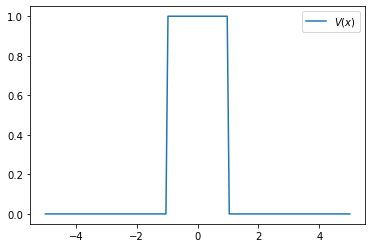

In [8]:
# Discretization of the x (position) coordinate
xmin = -5.0
xmax = 5.0
nx = 150
x = np.linspace(xmin, xmax, nx)

# Create array with the potential function values
Vfunc = V_barrier  # Select a specific potential energy function
V = np.zeros(nx, float) # potential initialized to V(x)=0 
for i, xpoint in enumerate(x):
    V[i] = Vfunc(xpoint)

# Plot the potential
plt.plot(x, V, label='$V(x)$')
plt.legend()
plt.show()

## Wavefunction

The TISE written above is a second order differential equation. Numerically, it is more convenient to deal with first order differential equations, so we use a standard trick and turn the second order equation into two coupled first order equations:

$$
\begin{align}
\nonumber \frac{d}{dx}\psi(x) & = S(x) \\
\nonumber \frac{d}{dx}S(x) & = -\frac{2m}{\hbar^2}\Big(E - V(x)\Big)\;\psi(x).
\end{align}
$$

These can be numerically integrated (we will do it from left to right) if we specify the two initial conditions
$\psi(x_\textrm{min})$ and $S(x_\textrm{min})$, and the total energy $E$. $x_\textrm{min}$ refers to the leftmost limit of the integration domain where we seek the solutions.

## Solve TISE

In [9]:
# The function defined in this cell solves the TISE for the specified
# potential by numerical integration of the second-order differetnial
# equation. It solves the TISE from left to right in the x domain and
# assumes that V=0 for x tending to plus/minus infinity

def integrate_tise(e, Vpot, alpha=0, mass=1.0, x0=-5.0, x1=5.0, xpoints = 150, inicond='sin'):
    """
    Integrate the 1D TISE numerically from left to right
    
    E       -- total energy of the particle
    Vpot    -- function, Vpot(x), the potential energy function
    alpha   -- phase of the solution at x0, [0,pi/2]
    mass    -- mass of the particle
    x0      -- leftmost point of integration
    x1      -- final point for the numerical integration, rightmost point in the domain
    xpoints -- number of points in the discretization of the x domain
    inicond -- "iexpR": complex exponential initial conditions, the particle has net momentum to the right
               "iexpL": complex exponential initial conditions, the particle has net momentum to the left
               "sin": sin(kx + alpha) real initial conditions
    """
    X = np.linspace(x0, x1, xpoints)
    # Set initial conditions
    if inicond == 'iexpR':
        psi0 = np.exp(1j*np.sqrt(2*mass*e)*x0 + 1j*alpha)
        s0 = 1j*np.sqrt(2*mass*e)*psi0
    elif inicond == 'iexpL':
        psi0 = np.exp(-1j*np.sqrt(2*mass*e)*x0 + 1j*alpha)
        s0 = -1j*np.sqrt(2*mass*e)*psi0
    elif inicond == 'sin':
        psi0 = np.sin(np.sqrt(2*mass*e)*x0 + alpha)
        s0 = np.sqrt(2*mass*e)*np.cos(np.sqrt(2*mass*e)*x0 + alpha)
    else:
        raise ValueError()
    f0 = np.array([psi0,s0], complex)
    
    # Define the function that returns the first order derivatives
    def dfunc(xvalue, F):
        return F[1], 2*mass*(Vpot(xvalue)-e)*F[0]
    
    # Initialize the differential equation solver
    solver = complex_ode(dfunc)
    solver.set_integrator('vode', atol=1.0e-8)
    solver.set_initial_value(f0, x0)
    # The solution for the psi and S functions will be stored in the matrix f of size (xpoints x 2)
    f = np.zeros((xpoints, 2), complex)
    
    # Integrate!
    f[0] = f0
    k = 1
    while solver.successful() and solver.t < x1:
        solver.integrate(x[k])
        f[k] = solver.y
        k += 1
    
    # Return solution
    psi = f.T[0] # T transposes the f matrix. psi(x) and s(x) are in the rows of the transposed f matrix
    s = f.T[1]
    return psi, s, X

## 1D Scattering at a Potential

<div>
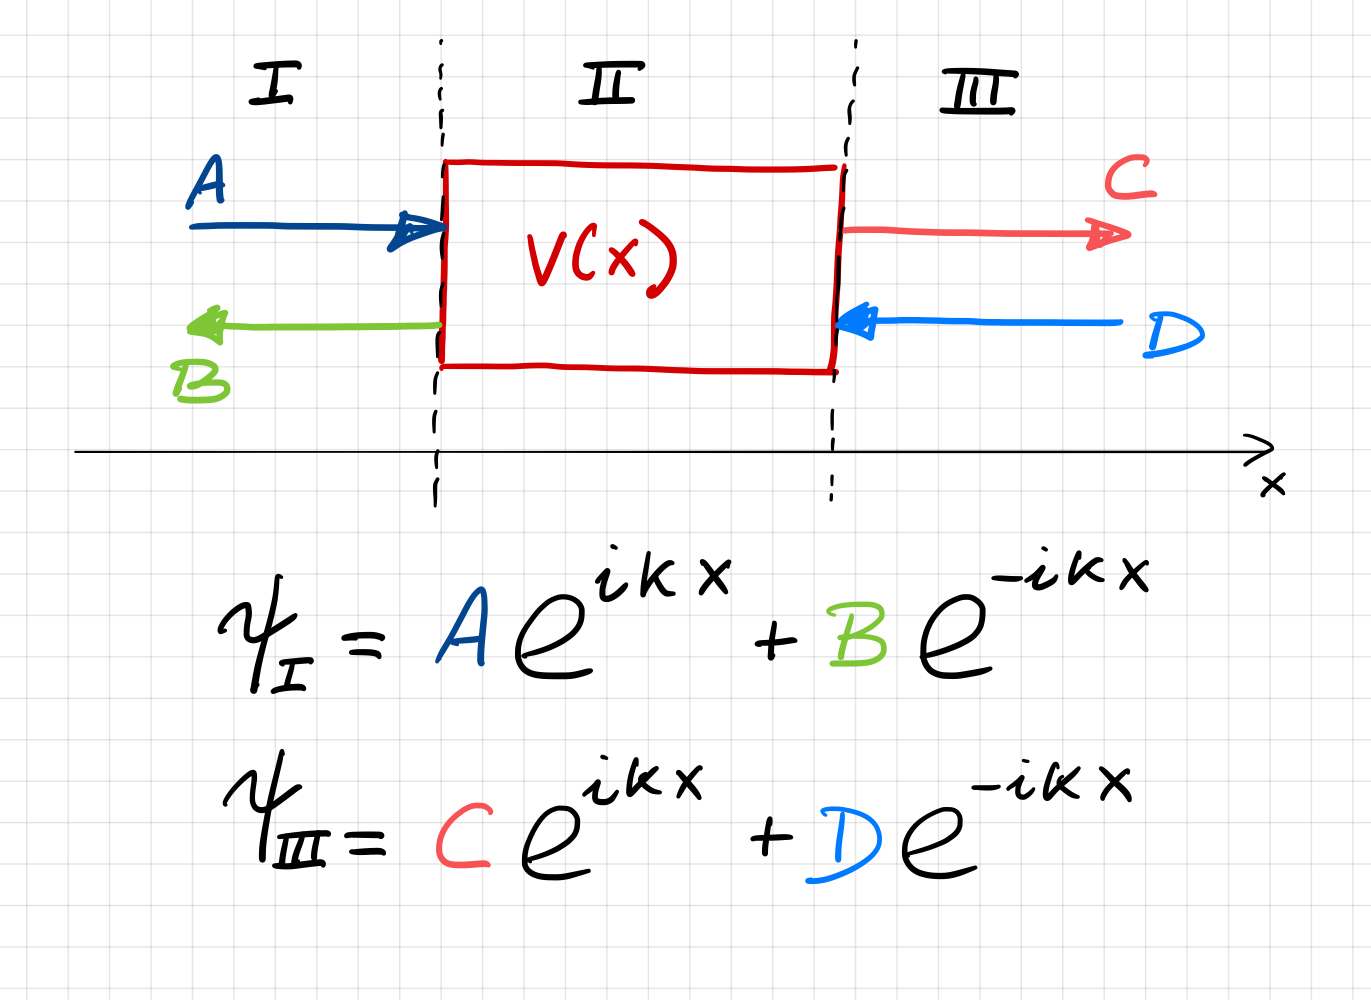
</div>

In this example we explore the phenomenon of tunneling. We must imagine the situation as a scattering experiment where we have two sources $A$ and $D$ that shoot the particle (it is the same particle!) to the potential. Out of the potential, the particle emerges with amplitude $B$ towards the left and $C$ towards the right. We want to solve the TISE for the usual situation that the particle is coming from one specific direction, say from the right.

In this scattering situation the source term is the $D$ amplitude. We could set the initial conditions for $D=1$ specifying $E$ and the initial wavefunction $\psi_R(x_\textrm{max}) = \exp(i k x_\textrm{max})$, and then numerically solve the TISE from right to left. This, however, does not work. We would get, of course, a solution of the TISE at energy $E$ with a plane wave on the right hand side and with negative momentum only. However, this scenario implicitly assumes that $C=0$, because we initially impose a plane wave propagating towards the left. How can this be? Will there be no reflection of the $D$ wave at the barrier? Well, of course there will be some reflection, but in our integrated solution this contribution will exactly cancel with the transmitted wave that originates from the source $A$. This is not what we want, we want only incoming flux from the right!

As you can see, this is a strange way to concieve a scattering experiment because, in it, both sources would be active. We can, instead, integrate backwards from the left. If our only source is $D$, we are 100% sure that there is no incoming particle from $A$ and therefore the solution on the left side of the potential is necessarily $\psi_L(x) = \exp(-i k x)$. We start from these initial conditions, thus setting $A=0$, and then integrate numerically from left to right.

## Tunneling through a potential barrier

In the next cell one can change the energy of the incoming wave from the right interactively. On the left side we see always the same outgoing wave $\psi_L(x) = B \exp(-i k x)$ and on the right side of the potential we see the superposition of the reflected and incoming waves, $\psi_R(x) = C \exp(i k x) + D\exp(-i k x) $, respectively.

In the region of the potential, $x \in [-1.0,1.0]$, and for $E<1.0$, we see how the probability density to find the particle decreases exponentially from right to left. **This is quantum mechanical tunneling**: the particle has not enough kinetic energy to surmount the barrier classically!

For the case that $E>1.0$, the particle has enough energy to surmount the barrier classically. In quantum mechanics, the particle can however be reflected. This is the phenomenon of quantum reflection. Move the slider to energies in this range and see how on the right hand side we still have interference of incoming and outgoing waves (modulation of the $|\psi(x)|^2$). At certain energies close to $E=2.0$ the place with the largest probability to find the particle is at the barrier, as it is being slowed down there.

In [10]:
Vfunc = V_barrier
V = np.zeros(nx, float) # potential initialized to V(x)=0 
for i, xpoint in enumerate(x):
    V[i] = Vfunc(xpoint)

In [11]:
def plotWFN(E=1.0):
    PSI, S, X = integrate_tise(E, Vfunc, alpha=0,  mass=1.0, x0=-5.0, x1=5.0, xpoints = 150, inicond='iexpL')
    plt.xlim(-2.5,5.0)
    plt.ylim(-1,8)
    plt.plot(X, V*5, label='Pot') # scale potential for plotting
    plt.plot(X, np.abs(PSI)**2, label='$|\Psi(x)|^2$')
    #plt.plot(X, np.real(PSI))
    #plt.plot(X, np.imag(PSI))
interact(plotWFN, E=(0.5, 3, 0.1))

interactive(children=(FloatSlider(value=1.0, description='E', max=3.0, min=0.5), Output()), _dom_classes=('wid…

<function __main__.plotWFN(E=1.0)>

## Resonances: Reflection and Transmission Coefficients

We explore here the phenomenon of resonances and of the superposition of waves. As before, we study the scattering of an incoming wave from the right hand side, which now scatters on a double barrier potential. Since the particle is incoming from the right, the wave function at the left side of the two barriers is a plane wave solution $\psi_L(x) = 
B \exp(-i k x)$ with $|\psi_L(x)|^2 = \textrm{const.}$. In the region between the barriers and on the right side we find a modulation of the probability caused by the intereference of the incoming and reflected wave.

As we change the energy of the incomig particle we see that for some energies the wavefunction on the right hand side becomes a plane wave (set the slider e.g. at $E=1.30$ or $E=5.40$). At these energies there is no reflected wave, so $C=0$ in $\psi_R(x) = C \exp(i k x) + D\exp(-i k x) $. In this situation we observe a **perfect transmission** of the particle. This is a resonance phenomenon caused by the double barrier structure. In presence of the $R$ barrier only, there should be reflection at all energies (set `Vfunc = V_resonance2` below to test it by yourself), so the part of the reflected wave at the $R$ barrier must exactly cancel with the reflected wave from the $L$ barrier, although the particle is coming from the right, so how should it know in advance? 

In [12]:
Vfunc = V_resonance
V = np.zeros(nx, float) # potential initialized to V(x)=0 
for i, xpoint in enumerate(x):
    V[i] = Vfunc(xpoint)

In [13]:
MASS = 1.0 # change here to try different masses
def plotWFN(E=2.5):
    PSI, S, X = integrate_tise(E, Vfunc, alpha=0,  mass=MASS, x0=-5.0, x1=5.0, xpoints = 150, inicond='iexpL')
    plt.xlim(-5,5)
    plt.ylim(-1,8)
    plt.plot(X, V*2, label='Pot')
    plt.plot(X, np.abs(PSI)**2, label='$|\Psi(x)|^2$')
    #plt.plot(X, np.real(PSI))
    #plt.plot(X, np.imag(PSI))
interact(plotWFN, E=(0.05, 10, 0.05))

interactive(children=(FloatSlider(value=2.5, description='E', max=10.0, min=0.05, step=0.05), Output()), _dom_…

<function __main__.plotWFN(E=2.5)>

Finally, we quantify the amount of transmission, $T$, and reflection, $R$, caused by the scattering potential

$$
T = \frac{|B|^2}{|D|^2},\;\;\;\;R = \frac{|C|^2}{|D|^2},\;\;\;\; R+T=1,
$$

where $D$ is, as previously, the source amplitude, and we set $B=1$ for the outgoing wave towards the left (and $A=0$).

Since we numerically know the solution $\psi_R(x)$ at all points to the right of the scattering potential, we can solve for the $C$ and $D$ amplitudes. Let's pick two positions in the interval $x>2$, $x_a$ and $x_b$ (in the code we pick the last and the 20th bebore the last point). The wavefunction at these two points is $\psi_a$ and $\psi_b$, respectively.

We now have
$$
\begin{align}
\nonumber
\psi_a =& C \exp(i k x_a) + D\exp(-i k x_a) \\
\nonumber
\psi_b =& C \exp(i k x_b) + D\exp(-i k x_b)
\end{align}
$$

and define $\exp(i k x_{a(b)})\equiv a(b)$. The system of equations above can be written in matrix form as

$$
\begin{pmatrix}
\psi_a \\
\psi_b
\end{pmatrix}
=
\begin{pmatrix}
a & a^* \\
b & b^*
\end{pmatrix}
\begin{pmatrix}
C \\
D
\end{pmatrix}.
$$

To solve for the amplitudes we invert the matrix of plane wave amplitudes and arrive at the final working equation

$$
\begin{pmatrix}
a & a^* \\
b & b^*
\end{pmatrix}^{-1}
\begin{pmatrix}
\psi_a \\
\psi_b
\end{pmatrix}
=
\begin{pmatrix}
C \\
D
\end{pmatrix}.
$$

We can see these operations as projecting the solution of the TISE obtained by numerical integration onto the plane wave basis functions for incoming and outgoing waves.

In [14]:
Energies = np.linspace(0.1, 10, 100)
Trans = np.zeros(len(Energies))
Refle = np.zeros(len(Energies))
for i, e in enumerate(Energies):
    # Integrate TISE
    PSI, S, X = integrate_tise(e, Vfunc, 0, mass=MASS, x0=-5.0, x1=5.0, xpoints = 150, inicond='iexpL')
    # Store values at two points to the right of the scattering potential
    Pa = PSI[-1]
    Pb = PSI[-20]
    W = np.array([Pa, Pb], complex)
    # Calculate entries of the matrix of plane wave amplitudes
    a = np.exp( 1j*np.sqrt(2*MASS*e)*X[-1] )
    b = np.exp( 1j*np.sqrt(2*MASS*e)*X[-20] )
    M = np.array([[a, np.conj(a)], [b, np.conj(b)]], complex)
    # Invert the matrix
    iM = np.linalg.inv(M)
    # Solve the system
    CD = np.dot(iM, W)
    # Compute the transmission and reflection coefficients
    Trans[i] = 1.0/np.abs(CD[1])**2
    Refle[i] = np.abs(CD[0])**2/np.abs(CD[1])**2

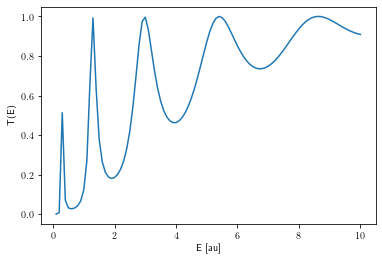

In [15]:
plt.xlabel('E [au]')
plt.ylabel('T(E)')
plt.plot(Energies, Trans)
#plt.plot(Energies, Refle)